<a href="https://colab.research.google.com/github/hucarlos08/GEE-CIMAT/blob/main/AggregatingTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aggregating Time Series Data: CHIRPS Monthly Precipitation

This notebook explores how to work with time series data in Google Earth Engine (GEE). We will focus on aggregating a high-temporal-resolution dataset into coarser time steps (e.g., daily or pentadal data into monthly summaries) and then plotting the results for a specific location.

## Learning Objectives

*   Manipulating dates and time ranges using the GEE API (`ee.Date`).
*   Filtering an `ImageCollection` by date.
*   Aggregating images within specific time intervals (e.g., summing pentadal rainfall into monthly totals) using mapping and reducers.
*   Creating a new `ImageCollection` from aggregated images.
*   Generating and customizing a time series chart for a specific point location.

## The CHIRPS Pentad Dataset

We will use the **Climate Hazards Group InfraRed Precipitation with Station data (CHIRPS)** dataset.

*   **What it is:** A globally gridded precipitation dataset spanning over 35 years (1981-present). It blends satellite-based infrared precipitation estimates with ground-based rain gauge data, providing a consistent and relatively high-resolution view of rainfall patterns, especially useful in data-sparse regions.
*   **Source:** Developed by the Climate Hazards Group at the University of California, Santa Barbara (UCSB-CHG).
*   **Version Used:** We'll use the **Pentad** version (`UCSB-CHG/CHIRPS/PENTAD`).
    *   A **pentad** is a 5-day period.
    *   There are 6 pentads per calendar month. The first 5 pentads are exactly 5 days long. The 6th pentad contains the remaining days of the month (3 to 6 days).
    *   Pentads reset at the beginning of each month (i.e., the 1st of the month is always the start of the first pentad).
    *   Each image in this collection represents the **total precipitation in millimeters (mm)** accumulated over that specific 5-day (or 3-6 day) pentad period.
*   **Resolution:** Approximately 5.5 km (0.05 degrees).
*   **Why it's useful:** Widely used for drought monitoring, climate change analysis, hydrological modeling, and agricultural applications.

## Why Aggregate CHIRPS Pentad Data?

The CHIRPS Pentad collection provides very detailed temporal information (72 images per year). However, for many analyses, this level of detail isn't needed or can be cumbersome. We often want to compare rainfall to other phenomena measured monthly (like vegetation indices - NDVI/EVI) or analyze seasonal/annual trends.

Therefore, a common task is to **aggregate** the pentadal data into coarser intervals, such as **total monthly precipitation**. This exercise will demonstrate exactly how to achieve this.

## Workflow Overview

1.  **Load Data:** Access the CHIRPS Pentad `ImageCollection`.
2.  **Define Time Range:** Specify the year(s) we want to analyze using `ee.Date` objects.
3.  **Initial Filter:** Filter the collection to include only images within our target year(s).
4.  **Define Aggregation Intervals:** Create a list of months (1-12).
5.  **Develop Monthly Aggregation Function:** Write a function that, for a given month number:
    *   Calculates the start and end dates of that specific month.
    *   Filters the yearly pentad collection to get only images within that month.
    *   Sums the precipitation values across all pentads within the month using `ee.Reducer.sum()`.
    *   Sets important metadata (`system:time_start`, `year`, `month`) on the resulting monthly sum image.
6.  **Map Function:** Apply (`map`) the aggregation function over the list of months to generate a list of 12 monthly precipitation images.
7.  **Create Monthly Collection:** Convert the list of images into a new `ImageCollection` representing the monthly totals.
8.  **Plot Time Series:**
    *   Define a point of interest (e.g., a city).
    *   Use GEE charting tools (adapted for Python) to plot the monthly precipitation values from the new collection at the point over time.
    *   Customize the chart for better readability.

## Key GEE Concepts

*   `ee.ImageCollection()`: Loading image datasets.
*   `ee.Date()`, `ee.Date.fromYMD()`, `date.advance()`: Creating and manipulating dates.
*   `date.millis()`: Getting the Unix timestamp (milliseconds since Jan 1, 1970), used for `system:time_start`.
*   `collection.filterDate()`, `ee.Filter.date()`: Filtering collections by time.
*   `ee.List.sequence()`: Creating lists of numbers (e.g., months, years).
*   `collection.map()`, `list.map()`: Applying a function to each element in a collection or list.
*   `collection.reduce()`: Aggregating images in a collection (e.g., using `ee.Reducer.sum()`).
*   `image.set()`: Setting properties (metadata) on an image.
*   `ee.ImageCollection.fromImages()`: Creating a collection from a list of images.

Let's begin implementing this workflow step-by-step in Python!

Google Earth Engine initialized successfully.
Target year set to: 2019
Loaded CHIRPS Pentad collection: UCSB-CHG/CHIRPS/PENTAD
Date range defined: 2019-01-01 to 2020-01-01
Number of CHIRPS images in 2019: 72

--- Date Object Examples ---
Start date object: {'type': 'Date', 'value': 1546300800000}
End date object: {'type': 'Date', 'value': 1577836800000}
Start date as timestamp (ms): 1546300800000
End date as timestamp (ms): 1577836800000
----------------------------

Starting monthly aggregation...
Created list of months (1-12).
Mapped aggregation function over months list.
Created monthly ImageCollection.
Properties of first monthly image: {'system:time_start': 1546300800000, 'month': 1, 'year': 2019, 'system:index': '0'}

Preparing time series plot...
Point of Interest (POI) set for CIMAT, Guanajuato, MX: [-101.260965, 21.042169]
Using scale: 5566 meters
Retrieving time series data...
Retrieved 12 data points.

DataFrame prepared for plotting:
            Precipitation_mm
Date       

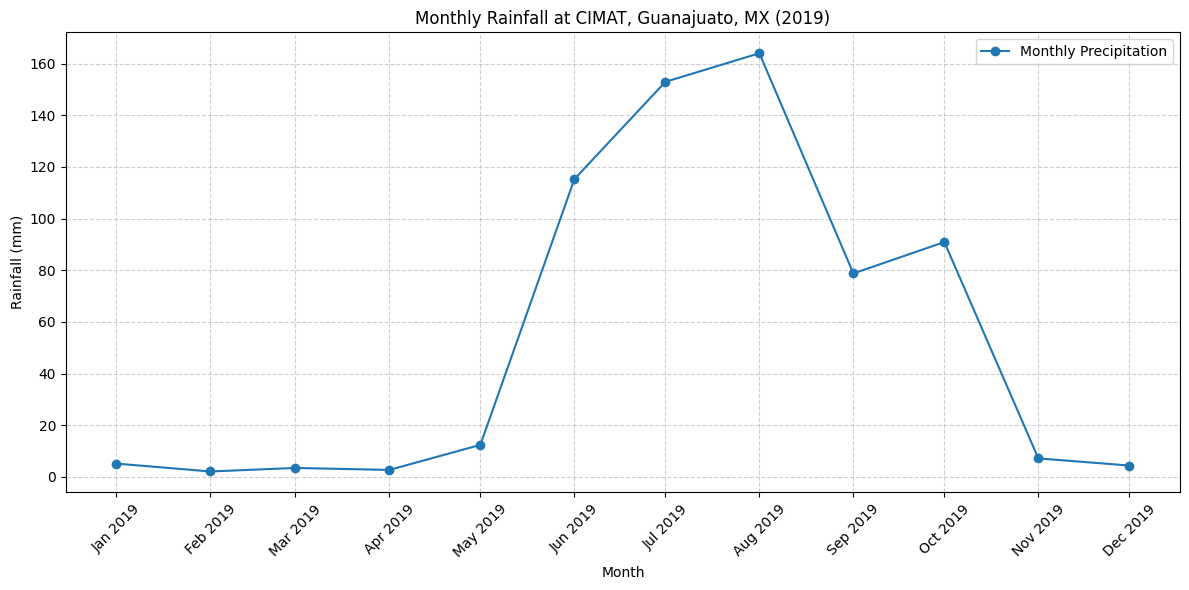


--- Script finished ---


In [ ]:
"""
Aggregating CHIRPS Precipitation Data to Monthly Totals and Plotting Time Series

This notebook demonstrates how to work with the CHIRPS Pentad precipitation
dataset in Google Earth Engine (GEE). We will aggregate the 5-day (pentadal)
data into monthly total precipitation sums and then plot the resulting time
series for a specific location (Bengaluru, India).

Steps:
1. Load the CHIRPS Pentad ImageCollection.
2. Define a target year and filter the collection for that year.
3. Create a function to calculate the total monthly precipitation for a given month.
4. Map this function over all 12 months of the year.
5. Convert the resulting list of monthly images into a new ImageCollection.
6. Define a point of interest (POI).
7. Extract the monthly precipitation values at the POI.
8. Plot the time series using matplotlib.
"""

# Import necessary libraries
import ee
import folium
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Helper function to add GEE tile layers to a Folium map (Optional, not strictly needed for charting)
def add_ee_layer(self, ee_image_object, vis_params, name):
  """Adds a Google Earth Engine tile layer to a Folium map."""
  if ee_image_object is None:
      print(f"Warning: Skipping layer '{name}' because the Earth Engine Image object is null.")
      return self
  try:
      map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
      folium.raster_layers.TileLayer(
          tiles=map_id_dict['tile_fetcher'].url_format,
          attr='Map Data © <a href="https://earthengine.google.com/">Google Earth Engine</a>',
          name=name,
          overlay=True,
          control=True
      ).add_to(self)
      print(f"Layer '{name}' added successfully.")
  except Exception as e:
      print(f"ERROR adding layer '{name}': {e}")
  return self

# Apply the helper function to folium.Map (Optional)
# folium.Map.add_ee_layer = add_ee_layer

# -----------------------------------------------------------------------------
# Authenticate and Initialize Google Earth Engine
# -----------------------------------------------------------------------------
try:
    ee.Initialize(project='ee-cimat')
    print("Google Earth Engine initialized successfully.")
except Exception as e:
    print(f"Earth Engine initialization failed: {e}")
    print("Attempting authentication...")
    ee.Authenticate()
    ee.Initialize(project='ee-cimat')
    print("Google Earth Engine authenticated and initialized successfully.")

# -----------------------------------------------------------------------------
# Configuration and Data Loading
# -----------------------------------------------------------------------------

# 1. Define Target Year
target_year = 2019
print(f"Target year set to: {target_year}")

# 2. Load CHIRPS Pentad Collection
chirps_collection_id = 'UCSB-CHG/CHIRPS/PENTAD'
chirps = ee.ImageCollection(chirps_collection_id)
print(f"Loaded CHIRPS Pentad collection: {chirps_collection_id}")

# 3. Define Start and End Dates for the Target Year
# Use ee.Date objects for date manipulation in GEE
start_date = ee.Date.fromYMD(target_year, 1, 1) # January 1st of the target year

# The end date should be exclusive, so we go to Jan 1st of the *next* year
end_date = start_date.advance(1, 'year') # Advance by exactly one year
print(f"Date range defined: {start_date.format('YYYY-MM-dd').getInfo()} to {end_date.format('YYYY-MM-dd').getInfo()}")

# 4. Filter CHIRPS Collection for the Target Year
year_filtered = chirps.filterDate(start_date, end_date)
# Check the size - should be approx 72 images (365 days / ~5 days/pentad)
print(f"Number of CHIRPS images in {target_year}: {year_filtered.size().getInfo()}")

# -----------------------------------------------------------------------------
# Section 2: Working with Dates & Preparing for Aggregation
# -----------------------------------------------------------------------------
# This section mirrors the logic from the text, demonstrating date objects.
# The actual filtering was done above, but we confirm date objects work.

# Example of creating date objects and getting timestamps (millis)
print("\n--- Date Object Examples ---")
print('Start date object:', start_date.getInfo()) # Show server-side representation
print('End date object:', end_date.getInfo())
print('Start date as timestamp (ms):', start_date.millis().getInfo())
print('End date as timestamp (ms):', end_date.millis().getInfo())
print("----------------------------\n")

# -----------------------------------------------------------------------------
# Section 3: Aggregating Images to Monthly Totals
# -----------------------------------------------------------------------------
print("Starting monthly aggregation...")

# 1. Create a list of months (1 to 12)
# Use ee.List.sequence for server-side list generation
months = ee.List.sequence(1, 12)
print("Created list of months (1-12).")

# 2. Define a function to calculate total precipitation for a given month
# This function will be mapped over the 'months' list.
# It needs access to the 'target_year' and the 'year_filtered' collection.
def create_monthly_image(month_number):
    """Calculates total monthly precipitation for a given month number."""
    # Cast the input month number to an ee.Number
    month_ee = ee.Number(month_number)

    # Calculate the start date for this specific month
    month_start = ee.Date.fromYMD(target_year, month_ee, 1)
    # Calculate the end date for this month (exclusive)
    month_end = month_start.advance(1, 'month')

    # Filter the already year-filtered collection for this specific month
    month_filtered = year_filtered.filterDate(month_start, month_end)

    # Calculate the sum of precipitation for all pentads within the month
    # The result is a single image with one band (default name 'precipitation_sum')
    total_precipitation = month_filtered.reduce(ee.Reducer.sum())

    # Set important properties on the resulting monthly image
    # system:time_start is crucial for time series analysis and charting
    # Set it to the beginning of the month in milliseconds
    # Also set 'year' and 'month' properties for easier filtering later if needed
    return total_precipitation.set({
        'system:time_start': month_start.millis(),
        # 'system:time_end': month_end.millis(), # Optional, time_start usually sufficient
        'year': target_year,
        'month': month_ee
    }).rename('monthly_precipitation') # Rename the band for clarity

# 3. Map the function over the list of months
# This executes create_monthly_image for each number from 1 to 12
# The result is an ee.List object containing 12 ee.Image objects
monthly_images_list = months.map(create_monthly_image)
print("Mapped aggregation function over months list.")

# 4. Create an ImageCollection from the list of monthly images
monthly_collection = ee.ImageCollection.fromImages(monthly_images_list)
print("Created monthly ImageCollection.")

# Optional: Print the monthly collection to inspect its structure and properties
# Expand the output in Colab to see the 12 images and their properties (year, month, time_start)
# print("Monthly Collection Info:", monthly_collection.getInfo()) # Can be large output

# Check the first image's properties as an example
print("Properties of first monthly image:", monthly_collection.first().getInfo()['properties'])

# -----------------------------------------------------------------------------
# Section 4: Plotting Time Series
# -----------------------------------------------------------------------------
print("\nPreparing time series plot...")

# --- Location Definitions ---

# Add more locations as needed
locations = {
    'bengaluru': {
        'name': 'Bengaluru, India',
        'coords': [77.5946, 12.9716] # lon, lat
    },
    'cimat_gto': {
        'name': 'CIMAT, Guanajuato, MX',
        'coords': [-101.260965, 21.042169] # Approximate coords for CIMAT, Guanajuato
    },
    # Example: Add another location
    'sacramento_ca': {
        'name': 'Sacramento, CA, USA',
        'coords': [-121.4944, 38.5816]
    }
}

# --- CHOOSE LOCATION FOR ANALYSIS ---
# CHANGE THE KEY HERE TO SWITCH LOCATIONS
selected_location_key = 'cimat_gto'

# 1. Select Location Data based on the chosen key
if selected_location_key not in locations:
    raise ValueError(f"Error: selected_location_key '{selected_location_key}' is not a valid key in the locations dictionary. Choose from: {list(locations.keys())}")

selected_location_info = locations[selected_location_key]
location_name = selected_location_info['name']
location_coords = selected_location_info['coords']

# 2. Define Point of Interest (POI) using selected coordinates
poi = ee.Geometry.Point(location_coords) # Pass the list [lon, lat] directly
print(f"Point of Interest (POI) set for {location_name}: {location_coords}")

# 2. Define Scale
# CHIRPS resolution is approx 0.05 degrees, which is ~5566 meters at the equator
scale = 5566 # Meters
print(f"Using scale: {scale} meters")

# 3. Extract Time Series Data at the POI
# We need to get the precipitation value for each image in the monthly collection at the POI.
# Map a function over the collection to extract the value and date for each image.
def extract_value_at_poi(image):
    """Extracts mean precipitation value and date at the POI for an image."""
    # Reduce the image region at the POI. Using mean is safe even for a point.
    # Specify the reducer, geometry, and scale.
    reduction_dict = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=poi,
        scale=scale,
        maxPixels=1 # Only need value at the point pixel
    ) # Keep this as a server-side dictionary object first

    # Get the value for the band from the dictionary.
    # Provide the default value '0' directly to the .get() method.
    # This handles the case where the key 'monthly_precipitation' might be missing
    # if the reduction yielded no result for that band (e.g., masked pixel).
    mean_value_obj = reduction_dict.get('monthly_precipitation', 0) # Provide default here

    # Ensure the result is cast to ee.Number for consistency
    value_to_set = ee.Number(mean_value_obj)

    # Return a feature with null geometry, containing the date and precipitation value
    return ee.Feature(None, {
        'precipitation': value_to_set, # Use the potentially defaulted value
        'system:time_start': image.get('system:time_start') # Get the timestamp
    })

# Map the extraction function over the monthly collection
poi_monthly_data = monthly_collection.map(extract_value_at_poi)

# 4. Retrieve Data Client-Side
# Use getInfo() to bring the FeatureCollection data from GEE servers to Colab.
# This can be slow for very long time series or large regions.
print("Retrieving time series data...")
try:
    monthly_data_features = poi_monthly_data.getInfo()['features']
    print(f"Retrieved {len(monthly_data_features)} data points.")
except Exception as e:
    print(f"ERROR retrieving data: {e}")
    print("This might be due to computation limits or network issues.")
    exit() # Stop if data retrieval fails

# Check if data was retrieved
if not monthly_data_features:
    print("ERROR: No data features retrieved. Cannot plot.")
    exit()

# 5. Process Data for Plotting using Pandas
# Extract dates and precipitation values into lists, then create a Pandas DataFrame
dates = []
precipitation = []
for feature in monthly_data_features:
    # Convert milliseconds timestamp to datetime object
    dt_object = datetime.fromtimestamp(feature['properties']['system:time_start'] / 1000)
    dates.append(dt_object)
    precipitation.append(feature['properties']['precipitation'])

# Create a Pandas DataFrame - makes plotting easier
df = pd.DataFrame({'Date': dates, 'Precipitation_mm': precipitation})
# Set Date as the index for easier time series plotting
df = df.set_index('Date')
# Sort by date just in case the collection order wasn't guaranteed
df = df.sort_index()

print("\nDataFrame prepared for plotting:")
print(df.head()) # Print first few rows

# 6. Plot the Time Series using Matplotlib
print("\nGenerating plot...")
fig, ax = plt.subplots(figsize=(12, 6)) # Create a figure and an axes object

ax.plot(
    df.index, # Use the datetime index for the x-axis
    df['Precipitation_mm'], # Use the precipitation column for the y-axis
    marker='o', # Add points to the line
    linestyle='-',
    label='Monthly Precipitation'
)

# Customize the plot (similar to setOptions in GEE JavaScript)
ax.set_title(f'Monthly Rainfall at {location_name} ({target_year})')
ax.set_xlabel('Month')
ax.set_ylabel('Rainfall (mm)')
ax.grid(True, linestyle='--', alpha=0.6) # Add grid lines
ax.legend()

# Format the x-axis to show month names nicely
import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.MonthLocator()) # Tick mark for every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) # Format as 'Jan 2019'
plt.xticks(rotation=45) # Rotate labels for better readability

# Adjust layout and display the plot
plt.tight_layout()
plt.show()